In [71]:
# Telling matplotlib to plot graphs inline
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import csv
import cPickle as pickle
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import sys
import theano
import time
from matplotlib import cm

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import cPickle as pickle

In [8]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
FLOOKUP ='../data/IdLookupTable.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

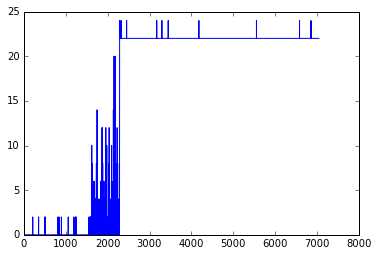

In [42]:
y_count_na = np.sum(np.isnan(y),1)
plt.plot(y_count_na)

In [69]:
idx_ds_2 = y_count_na.tolist().index(22)

img_ds_30 = X[:idx_ds_2]
img_ds_8 = X[idx_ds_2:]

train_ds_30 = y[:idx_ds_2]
train_ds_8 = y[idx_ds_2:]

print img_ds_30.shape, img_ds_8.shape
print train_ds_30.shape, train_ds_8.shape

(2284, 9216) (4765, 9216)
(2284, 30) (4765, 30)


In [61]:
keypoints = ['left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y','left_eye_inner_corner_x', \
             'left_eye_inner_corner_y','left_eye_outer_corner_x','left_eye_outer_corner_y','right_eye_inner_corner_x', \
             'right_eye_inner_corner_y','right_eye_outer_corner_x','right_eye_outer_corner_y','left_eyebrow_inner_end_x', \
             'left_eyebrow_inner_end_y','left_eyebrow_outer_end_x','left_eyebrow_outer_end_y','right_eyebrow_inner_end_x', \
             'right_eyebrow_inner_end_y','right_eyebrow_outer_end_x','right_eyebrow_outer_end_y','nose_tip_x','nose_tip_y', \
             'mouth_left_corner_x','mouth_left_corner_y','mouth_right_corner_x','mouth_right_corner_y', \
             'mouth_center_top_lip_x','mouth_center_top_lip_y','mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']

keypoints_ds_8 = [0,1,2,3,20,21,28,29]


train_ds_8_sub = train_ds_8[:,keypoints_ds_8]
print train_ds_8_sub.shape

(4765, 8)


(4755, 9216) (2140, 9216)
(4755, 8) (2140, 30)


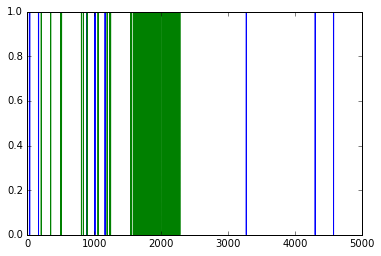

In [70]:
train_8_nona_idx = np.sum(np.isnan(train_ds_8_sub),1) == 0
train_30_nona_idx = np.sum(np.isnan(train_ds_30),1) == 0

img_8_nona = img_ds_8[train_8_nona_idx]
img_30_nona = img_ds_30[train_30_nona_idx]

train_8_nona = train_ds_8_sub[train_8_nona_idx]
train_30_nona = train_ds_30[train_30_nona_idx]

print img_8_nona.shape, img_30_nona.shape
print train_8_nona.shape, train_30_nona.shape

plt.plot(train_8_nona_idx)
plt.plot(train_30_nona_idx)

In [88]:
def float32(var):
    return np.cast['float32'](var)


#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-4, 1e-2)
    plt.yscale("log")
    plt.show()

In [75]:
net_8 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
#         ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
#         ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
#         ('dropout3', layers.DropoutLayer),  # !
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
#         ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
#     dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
#     dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
#     dropout3_p=0.3,  # !
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
#     dropout3_p=0.4,  # !
    hidden5_num_units=500,
#     dropout4_p=0.5,  # !
    hidden6_num_units=500,
    hidden7_num_units=500,
    output_num_units=8, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=1000,
    verbose=1,
    )

In [76]:
sys.setrecursionlimit(10000)

img_8_nona_2d = img_8_nona.reshape(len(img_8_nona), 1, 96, 96)
net_8.fit(img_8_nona_2d, train_8_nona)

graph_results(net_8)

with open('net_8.pickle', 'wb') as f:
    pickle.dump(net_8, f, -1)

# Neural Network with 13478308 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  conv4    256x10x10
  8  pool4    256x10x10
  9  hidden5  500
 10  hidden6  500
 11  hidden7  500
 12  output   8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02618     0.00809    3.23552  4.95s
      2     0.00657     0.00786    0.83555  4.95s
      3     0.00652     0.00784    0.83212  4.94s
      4     0.00653     0.00782    0.83548  4.94s
      5     0.00654     0.00778    0.83996  4.94s
      6     0.00654     0.00774    0.84508  4.94s
      7     0.00654     0.00769    0.85061  4.95s
      8     0.00654     0.00766    0.85428  4.94s
      9     0.00654     0.00762    0.85775  4.94s
     10     0.00653     0.00759    0.86140  4.94s
   

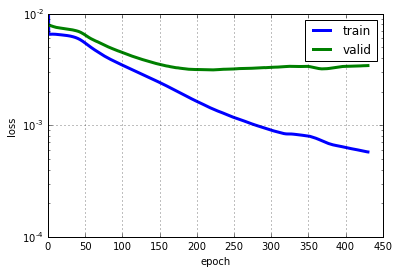

In [89]:
graph_results(net_8)

In [82]:
net_8_d = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    dropout4_p=0.4,  # !
    hidden5_num_units=500,
    hidden6_num_units=500,
    hidden7_num_units=500,
    output_num_units=8, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

# Neural Network with 13478308 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02156     0.01194    1.80551  5.24s
      2     0.00701     0.00984    0.71288  5.21s
      3     0.00688     0.00901    0.76427  5.21s
      4     0.00678     0.00846    0.80215  5.21s
      5     0.00673     0.00817    0.82348  5.22s
      6     0.00668     0.00796    0.83966  5.21s
      7     0.00666     0.00779    0.85471  5.22s
      8     0.00663     0.00768    0.863

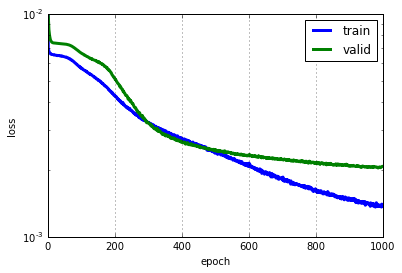

In [83]:
net_8_d.fit(img_8_nona_2d, train_8_nona)

graph_results(net_8_d)

with open('net_8_d.pickle', 'wb') as f:
    pickle.dump(net_8_d, f, -1)

In [85]:
net_30_d = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    dropout4_p=0.4,  # !
    hidden5_num_units=500,
    hidden6_num_units=500,
    hidden7_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

In [90]:
img_30_nona_2d = img_30_nona.reshape(len(img_30_nona), 1, 96, 96)
net_30_d.fit(img_30_nona_2d, train_30_nona)

     14     0.00509     0.00617    0.82574  2.36s
     15     0.00492     0.00600    0.82023  2.36s
     16     0.00505     0.00576    0.87554  2.35s
     17     0.00496     0.00557    0.89081  2.35s
     18     0.00497     0.00545    0.91244  2.35s
     19     0.00498     0.00536    0.92985  2.35s
     20     0.00495     0.00530    0.93367  2.35s
     21     0.00492     0.00521    0.94426  2.35s
     22     0.00494     0.00513    0.96234  2.35s
     23     0.00493     0.00508    0.97053  2.35s
     24     0.00490     0.00499    0.98205  2.35s
     25     0.00491     0.00496    0.98852  2.35s
     26     0.00490     0.00489    1.00321  2.35s
     27     0.00490     0.00484    1.01266  2.35s
     28     0.00489     0.00484    1.00915  2.35s
     29     0.00489     0.00477    1.02545  2.35s
     30     0.00487     0.00473    1.02994  2.35s
     31     0.00488     0.00475    1.02646  2.35s
     32     0.00490     0.00468    1.04716  2.35s
     33     0.00489     0.00465    1.05080  2.35s


IndexError: index 1000 is out of bounds for axis 0 with size 1000

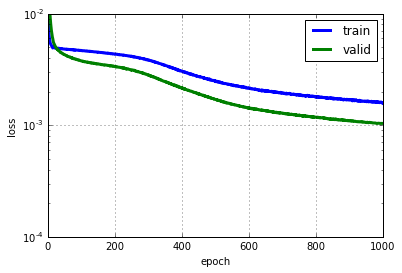

In [91]:
graph_results(net_30_d)

In [93]:
with open('net_30_d.pickle', 'wb') as f:
    pickle.dump(net_30_d, f, -1)

PicklingError: Can't pickle <class '__main__.AdjustVariable'>: it's not the same object as __main__.AdjustVariable

591


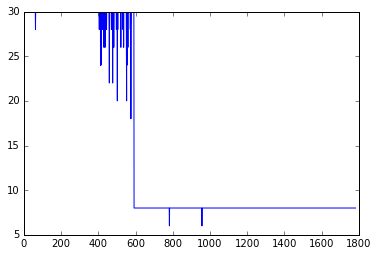

In [97]:
FLOOKUP = '../data/IdLookupTable.csv'
submissionImages = read_csv(os.path.expanduser(FLOOKUP))
subKeypoints = submissionImages.groupby(['ImageId']).size()
idx_sub_ds_8 = subKeypoints.tolist().index(8)
print idx_sub_ds_8
plt.plot(subKeypoints)

In [107]:
print submissionImages[:5]
print submissionImages[submissionImages['ImageId'] == 592]

   RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN
       RowId  ImageId                FeatureName  Location
17592  17593      592          left_eye_center_x       NaN
17593  17594      592          left_eye_center_y       NaN
17594  17595      592         right_eye_center_x       NaN
17595  17596      592         right_eye_center_y       NaN
17596  17597      592                 nose_tip_x       NaN
17597  17598      592                 nose_tip_y       NaN
17598  17599      592  mouth_center_bottom_lip_x       NaN
17599  17600      592  mouth_center_bottom_lip_y       NaN


In [108]:
# Prep test data
test_img, foo = load(test=True) 
test_img_30 = test_img[:idx_sub_ds_8]
test_img_8 = test_img[idx_sub_ds_8:]

print test_img_30.shape, test_img_8.shape

test_img_30_2d = test_img_30.reshape(len(test_img_30), 1, 96, 96)
test_img_8_2d = test_img_8.reshape(len(test_img_8), 1, 96, 96)

print test_img_30_2d.shape, test_img_8_2d.shape

ImageId    1783
Image      1783
dtype: int64
(591, 9216) (1192, 9216)
(591, 1, 96, 96) (1192, 1, 96, 96)


In [109]:
# Predictions
test_pred_30 = net_30_d.predict(test_img_30_2d)
test_pred_8 = net_8_d.predict(test_img_8_2d)

print test_pred_30.shape, test_pred_8.shape

(591, 30) (1192, 8)


In [128]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

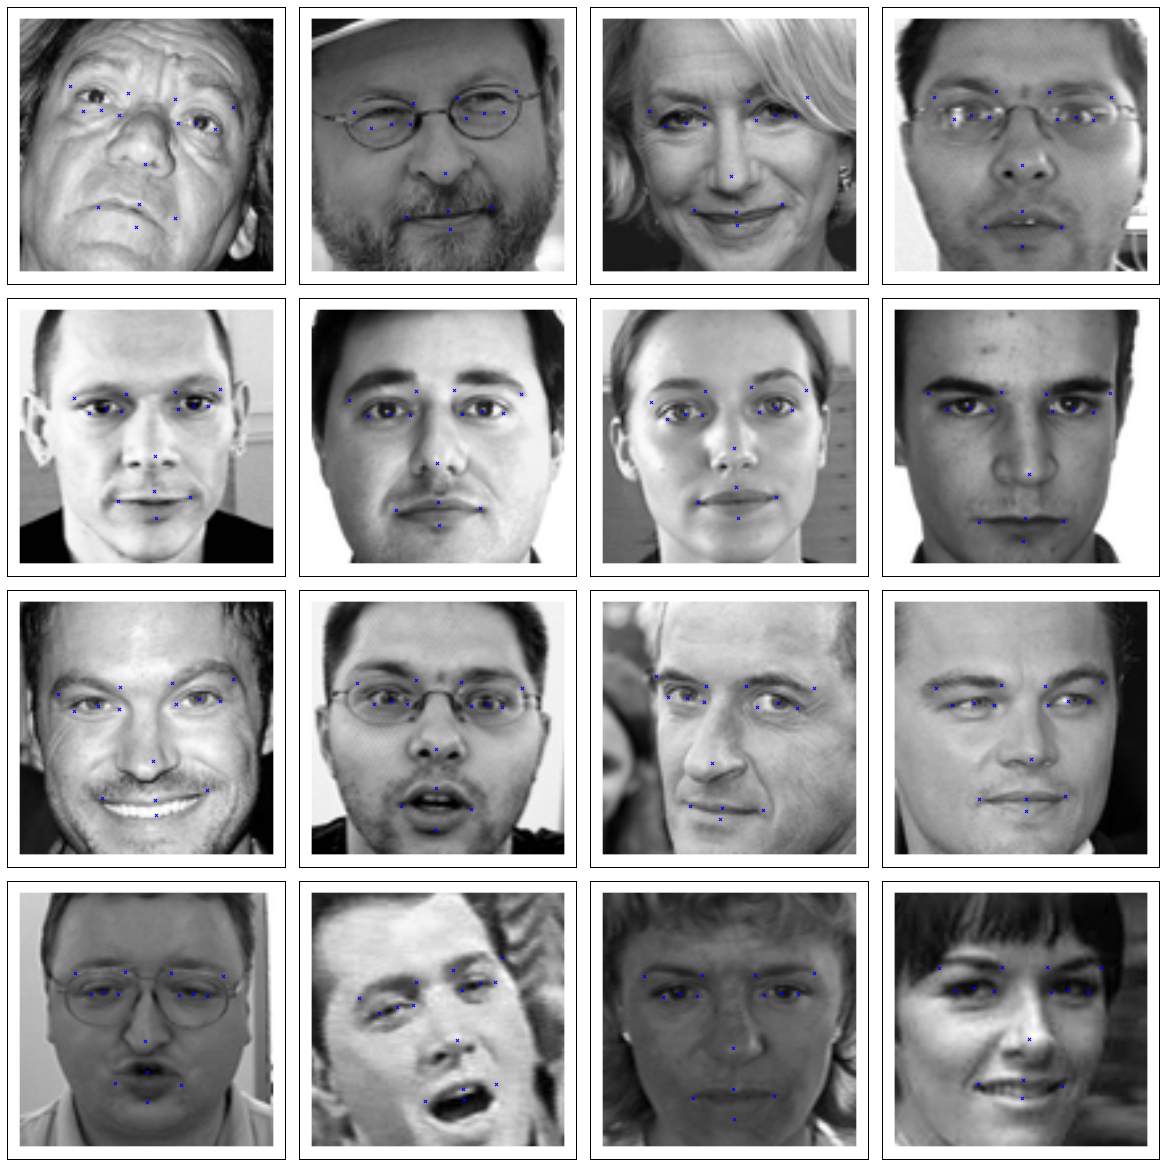

In [131]:
from random import randint

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_pred_30))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_30[test_idx], test_pred_30[test_idx], ax)
    
plt.show()

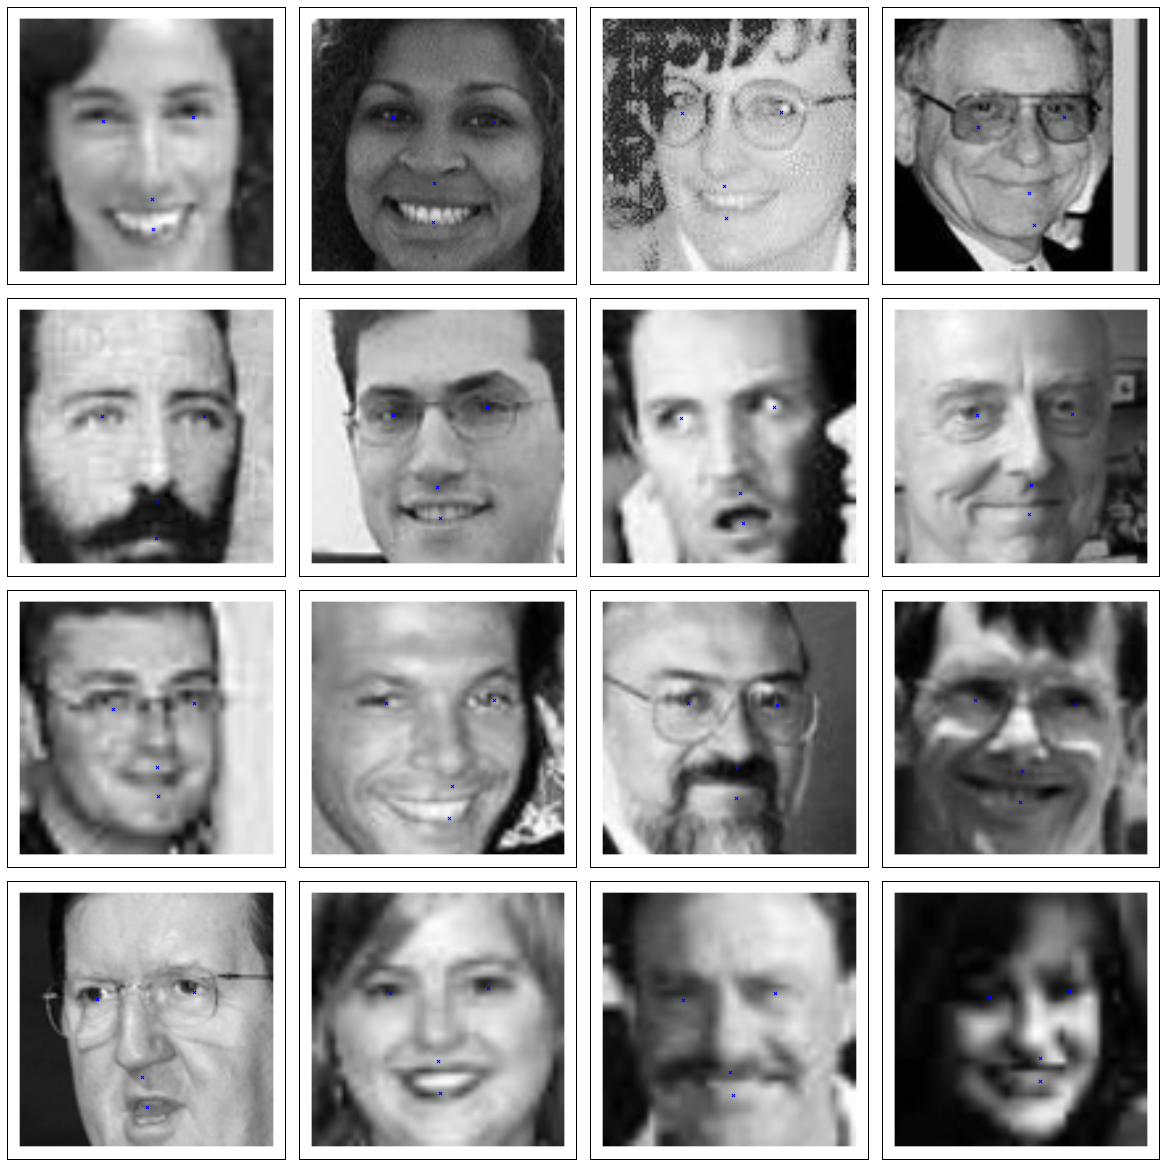

In [132]:
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_pred_8))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_8[test_idx], test_pred_8[test_idx], ax)
    
plt.show()

In [120]:
test_pred_30_fmt = test_pred_30 * 48 + 48
test_pred_8_fmt = test_pred_8 * 48 + 48

# Generating submissions
arr = [['RowId','ImageId','FeatureName','Location']]
rowIdx = 0

# Parsing first dataset
for i in range(0, test_pred_30.shape[0]):
    for j in range(0, 30):
        rowIdx += 1
        arr.append([rowIdx, i + 1, keypoints[j], test_pred_30_fmt[i,j]])
        
# Parsing second dataset
for i in range(0, test_pred_8.shape[0]):
    for idx, j in enumerate(keypoints_ds_8):
        rowIdx += 1
        # Note ImageId starts from 592 for ds 2
        arr.append([rowIdx, 591 + i + 1, keypoints[j], test_pred_8_fmt[i,idx]])

In [134]:
print len(arr), len(arr[0])
print submissionImages[:5]
print arr[:5]
print submissionImages[-5:]
print arr[-5:]
print pd.DataFrame(arr[1:], columns=arr[0])[:5]

27267 4
   RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN
[['RowId', 'ImageId', 'FeatureName', 'Location'], [1, 1, 'left_eye_center_x', 66.997818], [2, 1, 'left_eye_center_y', 36.702045], [3, 1, 'right_eye_center_x', 29.786068], [4, 1, 'right_eye_center_y', 36.385765]]
       RowId  ImageId                FeatureName  Location
27119  27120     1783         right_eye_center_y       NaN
27120  27121     1783                 nose_tip_x       NaN
27121  27122     1783                 nose_tip_y       NaN
27122  27123     1783  mouth_center_bottom_lip_x       NaN
27123  27124     1783  mouth_center_bottom_lip_y       NaN
[[27262, 1783, 'right_eye_center_y', 38.335541], [27263, 1783, 'nose_tip_x', 47.057869], [27264, 1783, 'nose

In [135]:
arr_df = pd.DataFrame(arr[1:], columns=arr[0])
submission = pd.merge(left = submissionImages, right=arr_df, how="left", \
                      left_on=["ImageId","FeatureName"], right_on=["ImageId","FeatureName"]) 
print submission[:5]
print submission[-5:]

   RowId_x  ImageId              FeatureName  Location_x  RowId_y  Location_y
0        1        1        left_eye_center_x         NaN        1   66.997818
1        2        1        left_eye_center_y         NaN        2   36.702045
2        3        1       right_eye_center_x         NaN        3   29.786068
3        4        1       right_eye_center_y         NaN        4   36.385765
4        5        1  left_eye_inner_corner_x         NaN        5   60.861343
       RowId_x  ImageId                FeatureName  Location_x  RowId_y  \
27119    27120     1783         right_eye_center_y         NaN    27262   
27120    27121     1783                 nose_tip_x         NaN    27263   
27121    27122     1783                 nose_tip_y         NaN    27264   
27122    27123     1783  mouth_center_bottom_lip_x         NaN    27265   
27123    27124     1783  mouth_center_bottom_lip_y         NaN    27266   

       Location_y  
27119   38.335541  
27120   47.057869  
27121   67.189705  
2

In [146]:
submissionSub = submission[[0,5]]
submissionSub.columns = ['RowId', 'Location']
submissionSub.to_csv('keypoint_submission_v0.3.csv', index=False)